Import packages

In [1]:
import os
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
import copy
from collections import OrderedDict
import time
import re  # Added import for regex operations

In [2]:
if not os.path.exists('/content/drive'):
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

Parse input datafile

In [4]:
# Function to load sequences, coverage data, and headers from file
def load_data(file_path):
    """Load sequences, coverage data, and headers from a FASTA-like file with the following
    structure: line1: >header, line2: sequence, line3: coverage data (repeated)

    Args:
        file_path (str): Path to the input file.

    Returns:
        headers (list): List of sequence headers.
        sequences (list): List of nucleotide sequences.
        coverage (list): List of coverage data corresponding to each sequence.
    """
    headers, sequences, coverage = [], [], []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        i = 0
        while i < len(lines):
            line = lines[i].strip()
            if line.startswith('>'):
                headers.append(line[1:].strip())
                i += 1
                if i < len(lines):
                    sequence_line = lines[i].strip()
                    sequences.append(sequence_line)
                    i += 1
                    if i < len(lines):
                        coverage_line = lines[i].strip()
                        coverage.append([int(x.strip()) for x in coverage_line.split(',')])
                        i += 1
                    else:
                        # Handle missing coverage line
                        coverage.append([])
                else:
                    # Handle missing sequence line
                    sequences.append('')
                    coverage.append([])
                    i += 1
            else:
                i += 1  # Skip lines that don't start with '>'
    return headers, sequences, coverage

Custom function for creating non-overlapping kmers

In [5]:
# Function to create overlapping k-mers from each sequence
def generate_overlapping_kmers(sequence, k=6):
    """Create overlapping k-mers from a nucleotide sequence.

    Args:
        sequence (str): Nucleotide sequence.
        k (int): Size of each k-mer (default is 6).

    Returns:
        kmers (list): List of overlapping k-mers.
    """
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

Load model from Huggingface

In [6]:
# Load the pre-trained nucleotide transformer model and tokenizer
model_name = "InstaDeepAI/nucleotide-transformer-500m-human-ref"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, from_tf=True)
model = AutoModel.from_pretrained(model_name).to('cuda' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Function to generate embeddings for k-mers
def generate_kmer_embeddings(kmers):
    inputs = tokenizer(kmers, return_tensors='pt', padding=True, truncation=True).to('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu()  # Mean-pooling for each k-mer's embedding

def first_coverage_for_kmers_overlapping(coverage, k=6):
    """
    Extracts the first coverage value from each overlapping k-mer window.

    Args:
        coverage (list of int): List of coverage values.
        k (int): Size of each k-mer window.

    Returns:
        list of float: First coverage value for each overlapping k-mer.
    """
    return [coverage[i] for i in range(len(coverage) - k + 1)]

# Function to normalize coverage values between 0 and 1
def normalize_coverage(coverage_values):
    if not coverage_values:
        return []  # Return empty list if no coverage data
    max_val = max(coverage_values)
    if max_val == 0:
        print("Warning: All coverage values are zero for a sequence.")
        return [0 for _ in coverage_values]
    return [val / max_val for val in coverage_values]

"""Functions to extract sample information and PicardTools metric"""

def extract_sample_info(filename):
    """
    Extracts the sample name and read length from the filename, assuming it is in the format:
    '{Sample}_{Readlength}bp.fa'
    For example: 'SampleA_100bp.fa'

    Args:
        filename (str): The filename to extract information from.

    Returns:
        tuple: (sample_name (str), readlength (int))
    """
    match = re.match(r'(.+?)_(\d+)bp\.fa$', filename)
    if match:
        sample_name = match.group(1)
        readlength = int(match.group(2))
        return sample_name, readlength
    else:
        raise ValueError(f"Cannot extract sample info from filename: {filename}")

# Function to get MEDIAN_5PRIME_TO_3PRIME_BIAS from PicardTools output
def get_median_5prime_to_3prime_bias(sample_name, readlength, picard_dir):
    """
    Given a sample name and read length, read the corresponding PicardTools output file and extract the MEDIAN_5PRIME_TO_3PRIME_BIAS value.

    Args:
        sample_name (str): Name of the sample.
        readlength (int): Read length.
        picard_dir (str): Directory where PicardTools output files are stored.

    Returns:
        float: MEDIAN_5PRIME_TO_3PRIME_BIAS value.
    """
    picard_filename = f"{sample_name}_{readlength}_Picard_RNA_Metrics.txt"
    picard_filepath = os.path.join(picard_dir, picard_filename)

    if not os.path.exists(picard_filepath):
        raise FileNotFoundError(f"PicardTools output file not found: {picard_filepath}")

    with open(picard_filepath, 'r') as f:
        lines = f.readlines()

    # Find the line that starts with "## METRICS CLASS" and read the next two lines
    for i, line in enumerate(lines):
        if line.startswith("## METRICS CLASS"):
            headers_line = lines[i+1].strip()
            values_line = lines[i+2].strip()
            break
    else:
        raise ValueError(f"Metrics section not found in PicardTools output file: {picard_filepath}")

    headers = headers_line.split('\t')
    values = values_line.split('\t')

    if 'MEDIAN_5PRIME_TO_3PRIME_BIAS' not in headers:
        raise ValueError(f"MEDIAN_5PRIME_TO_3PRIME_BIAS not found in headers in PicardTools output file: {picard_filepath}")

    idx = headers.index('MEDIAN_5PRIME_TO_3PRIME_BIAS')
    median_5prime_to_3prime_bias = float(values[idx])
    return median_5prime_to_3prime_bias

Loop through all files with different truncation lengths and create dataframe with the correct label included for each segment.

In [8]:
# Directories for training/validation data and PicardTools metrics
# Set location of train samples
data_dir_train_val = '/content/drive/My Drive/Colab/Bryan_Colab/train_samples_readlength/'
# Set location of train samples picardtools output
picard_dir_train_val = '/content/drive/My Drive/Colab/Bryan_Colab/Picardtools_outdir/readlength_samples_train/'

# Directories for test data and PicardTools metrics
# Set location of test samples
data_dir_test = '/content/drive/My Drive/Colab/Bryan_Colab/test_samples_readlength/'
# Set location of test samples picardtools output
picard_dir_test = '/content/drive/My Drive/Colab/Bryan_Colab/Picardtools_outdir/readlength_samples_test/'

# Generate file paths for all training samples
train_file_paths = [os.path.join(data_dir_train_val, f) for f in os.listdir(data_dir_train_val) if f.endswith('.fa')]

# Generate file paths for all test samples
test_file_paths = [os.path.join(data_dir_test, f) for f in os.listdir(data_dir_test) if f.endswith('.fa')]

# Sort the file paths for consistency
train_file_paths.sort()
test_file_paths.sort()

In [9]:
def process_data(file_paths, sequence_embeddings_dict, picard_dir):
    final_datasets = []
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        # Extract sample name and read length
        sample_name, truncation_length = extract_sample_info(filename)

        # Get MEDIAN_5PRIME_TO_3PRIME_BIAS from PicardTools output
        median_5prime_to_3prime_bias = get_median_5prime_to_3prime_bias(sample_name, truncation_length, picard_dir)

        # Step 1: Load sequence, coverage data, and headers
        headers, sequences, coverage = load_data(file_path)

        # Append sample name to headers
        headers = [f"{sample_name}_{h}" for h in headers]

        # Step 2: Create a DataFrame
        df_temp = pd.DataFrame({
            "header": headers,
            "sequence": sequences,
            "coverage": coverage
        })

        # Normalize the coverage values
        df_temp['coverage'] = df_temp['coverage'].apply(normalize_coverage)

        embeddings_list = []
        coverage_list = []
        picard_metric_list = []
        for idx, row in df_temp.iterrows():
            seq = row['sequence']
            cov = row['coverage']

            # Generate overlapping k-mers
            kmers = generate_overlapping_kmers(seq, 6)

            # Use sequence as the key for caching
            seq_key = seq

            # Check if the sequence's embedding is already computed
            if seq_key in sequence_embeddings_dict:
                kmer_embeddings = sequence_embeddings_dict[seq_key]
            else:
                # Generate embeddings for k-mers
                kmer_embeddings = generate_kmer_embeddings(kmers)
                # Store the embeddings in the dictionary
                sequence_embeddings_dict[seq_key] = kmer_embeddings

            # Reduce embeddings to a single scalar per k-mer
            kmer_embeddings_reduced = kmer_embeddings.mean(dim=1, keepdim=True)  # Shape: (num_kmers, 1)

            # First coverage value for overlapping k-mers
            coverage_values = first_coverage_for_kmers_overlapping(cov, 6)

            # Convert coverage values to tensor
            coverage_tensor = torch.tensor(coverage_values).unsqueeze(1)  # (num_kmers, 1)

            # Append to lists
            embeddings_list.append(kmer_embeddings_reduced)
            coverage_list.append(coverage_tensor)
            picard_metric_list.append(median_5prime_to_3prime_bias)  # Same value for each sequence in the file

        # Add embeddings, coverage tensors, and Picard metric to the DataFrame
        df_temp['embeddings'] = embeddings_list
        df_temp['coverage_tensors'] = coverage_list
        df_temp['picard_metric'] = picard_metric_list

        # Add truncation length as a label
        df_temp['label'] = truncation_length

        # Store in the final dataset list
        final_datasets.append(df_temp[['header', 'embeddings', 'coverage_tensors', 'picard_metric', 'label']])

    # Concatenate all datasets into one final DataFrame
    final_dataset = pd.concat(final_datasets, ignore_index=True)
    return final_dataset

Load and Process Training Data

In [10]:
start_time = time.time()

# Initialize embeddings cache
sequence_embeddings_dict = {}

# Process training data
final_train_dataset = process_data(train_file_paths, sequence_embeddings_dict, picard_dir_train_val)

# Display the final training dataset's shape and first few rows
print("Training Dataset Shape:", final_train_dataset.shape)
print(final_train_dataset.head())

# Print the total time taken
print(f"Total time taken: {time.time() - start_time:.2f} seconds")


Training Dataset Shape: (17304, 5)
                            header  \
0  SRR10072431_1_1:2307016-2308015   
1  SRR10072431_1_1:2403285-2404284   
2  SRR10072431_1_1:2589665-2590664   
3  SRR10072431_1_1:3489278-3490277   
4  SRR10072431_1_1:6621888-6622887   

                                          embeddings  \
0  [[tensor(-0.0008)], [tensor(-0.0008)], [tensor...   
1  [[tensor(-0.0009)], [tensor(-0.0008)], [tensor...   
2  [[tensor(-0.0009)], [tensor(-0.0009)], [tensor...   
3  [[tensor(-0.0009)], [tensor(-0.0009)], [tensor...   
4  [[tensor(-0.0008)], [tensor(-0.0011)], [tensor...   

                                    coverage_tensors  picard_metric  label  
0  [[tensor(0.2836)], [tensor(0.2836)], [tensor(0...       1.312799    100  
1  [[tensor(0.4882)], [tensor(0.4882)], [tensor(0...       1.312799    100  
2  [[tensor(0.2094)], [tensor(0.1990)], [tensor(0...       1.312799    100  
3  [[tensor(0.1270)], [tensor(0.1270)], [tensor(0...       1.312799    100  
4  [[tensor(0.

Load and Process Test Data

In [11]:
start_time = time.time()

# Process test data (using the same embeddings cache)
final_test_dataset = process_data(test_file_paths, sequence_embeddings_dict, picard_dir_test)

# Display the final test dataset's shape and first few rows
print("Test Dataset Shape:", final_test_dataset.shape)
print(final_test_dataset.head())

# Print the total time taken
print(f"Total time taken: {time.time() - start_time:.2f} seconds")

Test Dataset Shape: (7004, 5)
                            header  \
0  SRR11746074_1_1:2307016-2308015   
1  SRR11746074_1_1:2403285-2404284   
2  SRR11746074_1_1:2589665-2590664   
3  SRR11746074_1_1:3489278-3490277   
4  SRR11746074_1_1:6621888-6622887   

                                          embeddings  \
0  [[tensor(-0.0008)], [tensor(-0.0008)], [tensor...   
1  [[tensor(-0.0009)], [tensor(-0.0008)], [tensor...   
2  [[tensor(-0.0009)], [tensor(-0.0009)], [tensor...   
3  [[tensor(-0.0009)], [tensor(-0.0009)], [tensor...   
4  [[tensor(-0.0008)], [tensor(-0.0011)], [tensor...   

                                    coverage_tensors  picard_metric  label  
0  [[tensor(0.8000)], [tensor(0.8000)], [tensor(0...       0.063792    151  
1  [[tensor(0.4861)], [tensor(0.4861)], [tensor(0...       0.063792    151  
2  [[tensor(0.3750)], [tensor(0.3750)], [tensor(0...       0.063792    151  
3  [[tensor(1.)], [tensor(1.)], [tensor(1.)], [te...       0.063792    151  
4  [[tensor(0.2800)

Split Training Data into Training and Validation Sets

In [12]:
# Extract features, labels, and headers from the training dataset
embeddings_train_val = final_train_dataset['embeddings'].tolist()
coverage_train_val = final_train_dataset['coverage_tensors'].tolist()
picard_metric_train_val = final_train_dataset['picard_metric'].tolist()
y_train_val = final_train_dataset['label'].tolist()
headers_train_val = final_train_dataset['header'].tolist()

# Split the training data into training and validation sets (85% train, 15% validation)
embeddings_train_split, embeddings_val_split, coverage_train_split, coverage_val_split, picard_metric_train_split, picard_metric_val_split, y_train_split, y_val_split, headers_train_split, headers_val_split = train_test_split(
    embeddings_train_val, coverage_train_val, picard_metric_train_val, y_train_val, headers_train_val, test_size=0.15, random_state=42
)

print(f"Number of Training Samples: {len(embeddings_train_split)}")
print(f"Number of Validation Samples: {len(embeddings_val_split)}")

Number of Training Samples: 14708
Number of Validation Samples: 2596


Prepare the Test Data

In [13]:
# Extract features and labels from the test dataset
embeddings_test = final_test_dataset['embeddings'].tolist()
coverage_test = final_test_dataset['coverage_tensors'].tolist()
picard_metric_test = final_test_dataset['picard_metric'].tolist()
y_test = final_test_dataset['label'].tolist()
headers_test = final_test_dataset['header'].tolist()

# Display a sample tensor
print("Sample Training Embedding Tensor:", embeddings_train_split[0])
print("Sample Training Coverage Tensor:", coverage_train_split[0])
print("Embedding Shape:", embeddings_train_split[0].shape)
print("Coverage Shape:", coverage_train_split[0].shape)

Sample Training Embedding Tensor: tensor([[-0.0008],
        [-0.0009],
        [-0.0009],
        [-0.0009],
        [-0.0008],
        [-0.0008],
        [-0.0009],
        [-0.0009],
        [-0.0009],
        [-0.0008],
        [-0.0009],
        [-0.0009],
        [-0.0008],
        [-0.0008],
        [-0.0009],
        [-0.0009],
        [-0.0009],
        [-0.0008],
        [-0.0007],
        [-0.0008],
        [-0.0007],
        [-0.0008],
        [-0.0008],
        [-0.0009],
        [-0.0010],
        [-0.0008],
        [-0.0009],
        [-0.0009],
        [-0.0007],
        [-0.0009],
        [-0.0009],
        [-0.0010],
        [-0.0009],
        [-0.0010],
        [-0.0010],
        [-0.0009],
        [-0.0009],
        [-0.0008],
        [-0.0008],
        [-0.0009],
        [-0.0008],
        [-0.0008],
        [-0.0009],
        [-0.0008],
        [-0.0008],
        [-0.0008],
        [-0.0008],
        [-0.0007],
        [-0.0007],
        [-0.0009],
        [-0.0008

Create Custom Dataset Classes and DataLoaders

In [14]:
# Custom Dataset class
class KmerDataset(Dataset):
    """Custom PyTorch Dataset for k-mer embeddings, coverage data, and PicardTools metric.

    Attributes:
        embeddings_list (list): List of embedding tensors.
        coverage_list (list): List of coverage tensors.
        picard_metric_list (list): List of PicardTools metric values.
        labels (list): List of labels.
    """
    def __init__(self, embeddings_list, coverage_list, picard_metric_list, labels):
        """Initialize the dataset with features and labels.

        Args:
            embeddings_list (list): List of embedding tensors.
            coverage_list (list): List of coverage tensors.
            picard_metric_list (list): List of PicardTools metric values.
            labels (list): List of labels.
        """
        self.embeddings_list = embeddings_list
        self.coverage_list = coverage_list
        self.picard_metric_list = picard_metric_list
        self.labels = labels

    def __len__(self):
        """Return the total number of samples.

        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """Retrieve the input tensors and label at the specified index.

        Args:
            idx (int): Index of the data point.

        Returns:
            tuple: (embeddings_tensor, coverage_tensor, picard_metric, label)
        """
        embeddings_tensor = self.embeddings_list[idx]  # Tensor of shape (num_kmers, 1)
        coverage_tensor = self.coverage_list[idx]      # Tensor of shape (num_kmers, 1)
        picard_metric = torch.tensor(self.picard_metric_list[idx], dtype=torch.float).unsqueeze(0)  # Scalar tensor
        label = torch.tensor(self.labels[idx], dtype=torch.float)  # Ensure the labels are floats for regression
        return embeddings_tensor, coverage_tensor, picard_metric, label

In [15]:
# Create Dataset instances for training, validation, and testing
train_dataset = KmerDataset(embeddings_train_split, coverage_train_split, picard_metric_train_split, y_train_split)
val_dataset = KmerDataset(embeddings_val_split, coverage_val_split, picard_metric_val_split, y_val_split)
test_dataset = KmerDataset(embeddings_test, coverage_test, picard_metric_test, y_test)

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Display the number of batches in each DataLoader
print(f"Training Loader: {len(train_loader)} batches")
print(f"Validation Loader: {len(val_loader)} batches")
print(f"Testing Loader: {len(test_loader)} batches")

Training Loader: 460 batches
Validation Loader: 82 batches
Testing Loader: 219 batches


Model Architecture

In [16]:
class CNNStream(nn.Module):
    """CNN Stream for processing either embeddings or coverage data."""
    def __init__(self, num_features):
        super(CNNStream, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)

        # Second convolutional block
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)

        # Third convolutional block
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)

        # Fourth convolutional block
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(512)

        # Activation and pooling
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool1d(kernel_size=4)

        # Adaptive pooling to get fixed-size output
        self.adaptive_pool = nn.AdaptiveMaxPool1d(output_size=1)

    def forward(self, x):
        # x is (batch_size, num_features, seq_length)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)

        # Apply adaptive pooling
        x = self.adaptive_pool(x)  # x is now (batch_size, channels, 1)

        # Flatten
        x = x.view(x.size(0), -1)

        return x

class EnhancedKmerCNNRegressor(nn.Module):
    """Enhanced CNN Regressor model with two separate CNN streams for embeddings and coverage, and an additional feature."""

    def __init__(self, embedding_features, coverage_features):
        """Initialize the CNN regressor model with two CNN streams and fully connected layers.

        Args:
            embedding_features (int): Number of features in the embedding input.
            coverage_features (int): Number of features in the coverage input.
        """
        super(EnhancedKmerCNNRegressor, self).__init__()

        # Two CNN streams
        self.embedding_cnn = CNNStream(num_features=embedding_features)
        self.coverage_cnn = CNNStream(num_features=coverage_features)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.7)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.3)

        # Fully connected layers (initialized later based on input size)
        self.fc1 = None
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, embeddings, coverage, picard_metric):
        """Forward pass of the CNN regressor.

        Args:
            embeddings (torch.Tensor): Embedding input tensor of shape (batch_size, seq_length, embedding_features).
            coverage (torch.Tensor): Coverage input tensor of shape (batch_size, seq_length, coverage_features).
            picard_metric (torch.Tensor): PicardTools metric tensor of shape (batch_size, 1).

        Returns:
            torch.Tensor: Output tensor.
        """
        # Reshape inputs to (batch_size, num_features, seq_length) for Conv1d
        embeddings = embeddings.permute(0, 2, 1)
        coverage = coverage.permute(0, 2, 1)

        # Pass through CNN streams
        embeddings_out = self.embedding_cnn(embeddings)
        coverage_out = self.coverage_cnn(coverage)

        # Concatenate outputs with Picard metric
        x = torch.cat((embeddings_out, coverage_out, picard_metric), dim=1)

        # Initialize the first fully connected layer based on the concatenated size
        if self.fc1 is None:
            fc_input_size = x.size(1)
            self.fc1 = nn.Linear(fc_input_size, 256).to(x.device)

        # Fully connected layers with activation and dropout
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.fc4(x)

        return x

Training Process

In [17]:
# Determine device (GPU if available, else CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Get embedding and coverage feature sizes
embedding_features = train_dataset.embeddings_list[0].shape[1]
coverage_features = train_dataset.coverage_list[0].shape[1]

print(f"Embedding Features: {embedding_features}")
print(f"Coverage Features: {coverage_features}")

# Initialize the model
model = EnhancedKmerCNNRegressor(embedding_features=embedding_features, coverage_features=coverage_features).to(device)

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=6, verbose=True)

# Number of epochs
num_epochs = 100  # Adjust as needed

# Initialize variables for checkpointing
best_val_loss = float('inf')
best_model_state = copy.deepcopy(model.state_dict())

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

Using device: cuda
Embedding Features: 1
Coverage Features: 1


In [18]:
start_time = time.time()

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Iterate over batches in the training DataLoader
    for embeddings_batch, coverage_batch, picard_metric_batch, y_batch in train_loader:
        embeddings_batch = embeddings_batch.to(device)
        coverage_batch = coverage_batch.to(device)
        picard_metric_batch = picard_metric_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(embeddings_batch, coverage_batch, picard_metric_batch).squeeze()  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss

    # Calculate average training loss
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for embeddings_val_batch, coverage_val_batch, picard_metric_val_batch, y_val_batch in val_loader:
            embeddings_val_batch = embeddings_val_batch.to(device)
            coverage_val_batch = coverage_val_batch.to(device)
            picard_metric_val_batch = picard_metric_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)
            val_outputs = model(embeddings_val_batch, coverage_val_batch, picard_metric_val_batch).squeeze()  # Forward pass
            loss = criterion(val_outputs, y_val_batch)  # Compute loss
            val_loss += loss.item()  # Accumulate loss

    # Calculate average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Print training and validation loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Checkpointing: Save the model if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        # Set model save location
        torch.save(best_model_state, '/content/drive/My Drive/Colab/Bryan_Colab/best_two_stream_overlapping_meankmer_cnn_regressor_with_picard.pth')
        print(f"New best model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}")

    # Update the learning rate scheduler based on validation loss
    scheduler.step(val_loss)

# Save best model
# Set model save location
best_model_path = '/content/drive/My Drive/Colab/Bryan_Colab/best_two_stream_overlapping_meankmer_cnn_regressor_with_picard.pth'
torch.save(model.state_dict(), best_model_path)

# Print the total time taken
print(f"Total time taken: {time.time() - start_time:.2f} seconds")


Epoch [1/100], Training Loss: 1825.3538, Validation Loss: 302235.7153
New best model saved at epoch 1 with val_loss: 302235.7153
Epoch [2/100], Training Loss: 505.6737, Validation Loss: 328419.8834
Epoch [3/100], Training Loss: 485.2607, Validation Loss: 1157653.2896
Epoch [4/100], Training Loss: 442.0404, Validation Loss: 1285803.0686
Epoch [5/100], Training Loss: 425.6041, Validation Loss: 1210752.6799
Epoch [6/100], Training Loss: 418.5846, Validation Loss: 2528096.5152
Epoch [7/100], Training Loss: 401.9877, Validation Loss: 148121.4987
New best model saved at epoch 7 with val_loss: 148121.4987
Epoch [8/100], Training Loss: 391.3656, Validation Loss: 922333.5091
Epoch [9/100], Training Loss: 378.9584, Validation Loss: 353091.9931
Epoch [10/100], Training Loss: 369.2819, Validation Loss: 1386686.6250
Epoch [11/100], Training Loss: 367.5996, Validation Loss: 1457841.2927
Epoch [12/100], Training Loss: 349.1385, Validation Loss: 816218.4078
Epoch [13/100], Training Loss: 343.1750, Val

Evaluation

<ipython-input-19-8846e2bd2f9b>:216: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/Colab/Bryan_Colab/best_two_strea

Sequences with predictions closest to the ground truth:
                                    Header  Ground Truth  Predictions  \
1286   SRR17272561_1_1:244706040-244707039         139.0   139.000824   
5860     SRR6663668_1_12:49763147-49764146          75.0    75.004845   
6705     SRR8083957_1_13:29513230-29514229         101.0   100.992661   
4107   SRR24508196_1_9:127691108-127692107         101.0   101.009666   
3922      SRR24508196_1_19:7470549-7471548         101.0   100.990105   
6521    SRR7075185_1_5:151267702-151268701          75.0    75.010963   
6337     SRR7075185_1_16:69696610-69697609          75.0    75.011147   
1650       SRR19520478_1_1:2589665-2590664         126.0   126.012848   
4016   SRR24508196_1_3:127690948-127691947         101.0   100.986900   
6086      SRR6663668_1_4:39778685-39779684          75.0    75.016716   
5963     SRR6663668_1_17:63589423-63590422          75.0    75.018333   
5330     SRR30598213_1_8:56962543-56963542         150.0   149.98077

<ipython-input-19-8846e2bd2f9b>:104: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(
<ipython-input-19-8846e2bd2f9b>:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df.groupby('Ground Truth')['Predictions'].mean().reset_index()


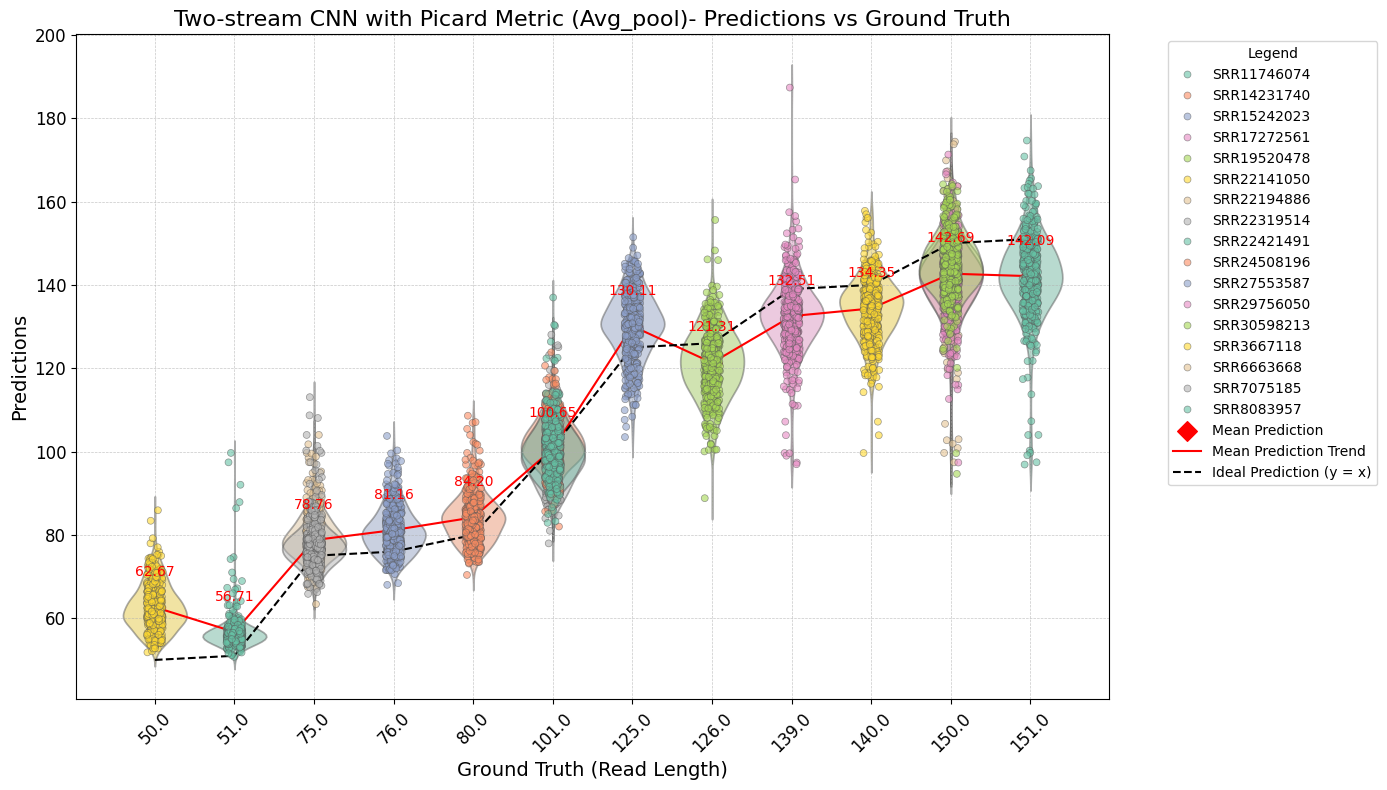

In [19]:
def evaluate_model(model, data_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Evaluate the model on a given DataLoader and collect predictions and ground truth.

    Args:
        model (nn.Module): Trained model.
        data_loader (DataLoader): DataLoader for the dataset to evaluate.
        device (str): Device to perform computation on.

    Returns:
        predictions (list): List of model predictions.
        ground_truth (list): List of actual labels.
    """
    model.eval()  # Set model to evaluation mode
    predictions, ground_truth = [], []
    with torch.no_grad():
        for embeddings_batch, coverage_batch, picard_metric_batch, y_batch in data_loader:
            embeddings_batch = embeddings_batch.to(device)
            coverage_batch = coverage_batch.to(device)
            picard_metric_batch = picard_metric_batch.to(device)
            outputs = model(embeddings_batch, coverage_batch, picard_metric_batch).squeeze()

            if outputs.dim() == 0:
                # If outputs is a scalar, append it directly
                predictions.append(outputs.item())
            else:
                # If outputs is an array, extend the predictions list
                predictions.extend(outputs.cpu().numpy())

            ground_truth.extend(y_batch.numpy())  # Collect ground truth labels
    return predictions, ground_truth

def calculate_metrics(predictions, ground_truth):
    """Calculate and print regression performance metrics.

    Args:
        predictions (list): List of model predictions.
        ground_truth (list): List of actual labels.

    Returns:
        tuple: (MAE, RMSE, R² Score)
    """
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)

    mae = mean_absolute_error(ground_truth, predictions)
    mse = mean_squared_error(ground_truth, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(ground_truth, predictions)

    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"R² Score: {r2:.3f}")

    return mae, rmse, r2

def plot_predictions_vs_gt(predictions, ground_truth, headers):
    """
    Plot a violin plot of model predictions against ground truth labels,
    with violin plots split by Sample and overlaid at the same x-position.
    Data points are colored by Sample, and mean predicted values are included.

    Args:
        predictions (list): List of model predictions.
        ground_truth (list): List of actual labels.
        headers (list): List of headers corresponding to each data point.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from collections import OrderedDict
    import pandas as pd
    import numpy as np

    # Create a DataFrame with ground truth, predictions, and headers
    df = pd.DataFrame({
        'Ground Truth': ground_truth,
        'Predictions': predictions,
        'Header': headers
    })

    # Extract 'Sample' from 'Header'
    df['Sample'] = df['Header'].apply(lambda x: x.split('_')[0])

    # Ensure 'Ground Truth' is sorted in order
    df['Ground Truth'] = df['Ground Truth'].astype(float)
    unique_gt = sorted(df['Ground Truth'].unique())
    df['Ground Truth'] = pd.Categorical(df['Ground Truth'], categories=unique_gt, ordered=True)

    plt.figure(figsize=(14, 8))

    # Plot violin plots per sample overlaid at the same x position
    sns.violinplot(
        x='Ground Truth',
        y='Predictions',
        data=df,
        hue='Sample',
        inner=None,
        dodge=False,
        palette='Set2',
        alpha=0.5
    )

    # Overlay the individual data points with transparency and jitter, colored by Sample
    sns.stripplot(
        x='Ground Truth',
        y='Predictions',
        data=df,
        hue='Sample',
        alpha=0.6,
        jitter=True,
        dodge=False,
        palette='Set2',
        marker='o',
        edgecolor='gray',
        linewidth=0.5
    )

    # Remove duplicate legends by collecting handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    # Remove 'Predictions' from labels if it exists (from violinplot)
    if 'Predictions' in by_label:
        del by_label['Predictions']

    # Calculate the mean predictions for each Ground Truth
    means = df.groupby('Ground Truth')['Predictions'].mean().reset_index()
    means['x_pos'] = range(len(means))  # x positions for the means

    # Plot the mean predictions as red diamond markers
    mean_scatter = plt.scatter(
        means['x_pos'],
        means['Predictions'],
        color='red',
        marker='D',
        s=100,
        label='Mean Prediction'
    )

    # Plot a line connecting the mean predictions
    mean_line, = plt.plot(
        means['x_pos'],
        means['Predictions'],
        color='red',
        linestyle='-',
        linewidth=1.5,
        label='Mean Prediction Trend'
    )

    # Plot the ideal prediction line (y = x)
    x_positions = means['x_pos']
    ideal_line, = plt.plot(
        x_positions,
        means['Ground Truth'].astype(float),
        'k--',
        label='Ideal Prediction (y = x)'
    )

    # Annotate the mean predicted values above each violin plot
    # Determine an offset based on data range for proper spacing
    y_min, y_max = df['Predictions'].min(), df['Predictions'].max()
    offset = (y_max - y_min) * 0.05  # 5% of the data range

    for i, row in means.iterrows():
        mean_pred = row['Predictions']
        plt.text(
            row['x_pos'],
            mean_pred + offset,
            f"{mean_pred:.2f}",
            ha='center',
            va='bottom',
            fontsize=10,
            color='red'
        )

    # Adjust x-ticks to correspond to ground truth values
    plt.xticks(
        ticks=means['x_pos'],
        labels=means['Ground Truth'],
        rotation=45,
        fontsize=12
    )

    # Add labels and title
    plt.title('Two-stream CNN with Picard Metric (Avg_pool)- Predictions vs Ground Truth', fontsize=16)
    plt.xlabel('Ground Truth (Read Length)', fontsize=14)
    plt.ylabel('Predictions', fontsize=14)
    plt.yticks(fontsize=12)

    # Add a grid with light dashed lines
    plt.grid(
        True,
        linestyle='--',
        linewidth=0.5,
        alpha=0.7
    )

    # Update legend to include mean prediction and ideal line
    # Collect handles and labels after plotting all elements
    handles, labels = plt.gca().get_legend_handles_labels()
    # Build a dictionary to remove duplicates
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(
        by_label.values(),
        by_label.keys(),
        title='Legend',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )

    # Adjust layout to prevent clipping of labels and legends
    plt.tight_layout()
    plt.show()

# Load the best model state from checkpoint
# Load from model save location
model.load_state_dict(torch.load('/content/drive/My Drive/Colab/Bryan_Colab/best_two_stream_overlapping_meankmer_cnn_regressor_with_picard.pth'))
model.to(device)
model.eval()

# Evaluate the model on the test set
test_predictions, test_ground_truth = evaluate_model(model, test_loader)

# Create a DataFrame with headers, predictions, and ground truth
df_results = pd.DataFrame({
    'Header': headers_test,
    'Ground Truth': test_ground_truth,
    'Predictions': test_predictions
})

# Extract 'Sample' from 'Header'
df_results['Sample'] = df_results['Header'].apply(lambda x: x.split('_')[0])

# Calculate absolute error
df_results['Absolute Error'] = abs(df_results['Predictions'] - df_results['Ground Truth'])

# Sort the DataFrame by Absolute Error
df_results_sorted = df_results.sort_values('Absolute Error')

# Display sequences with predictions closest to the ground truth
print("Sequences with predictions closest to the ground truth:")
print(df_results_sorted.head(30))

# Calculate and display performance metrics
mae, rmse, r2 = calculate_metrics(test_predictions, test_ground_truth)

# Call the modified plotting function
plot_predictions_vs_gt(test_predictions, test_ground_truth, headers_test)

In [20]:
def create_mean_predictions_table(predictions, ground_truth, headers):
    """
    Create a table summarizing the mean predictions and error for each sample at each read length.

    Args:
        predictions (list or array-like): List of model predictions.
        ground_truth (list or array-like): List of actual read lengths.
        headers (list or array-like): List of headers corresponding to each data point.

    Returns:
        pd.DataFrame: A DataFrame with columns ['Sample', 'Read Length', 'Predicted Mean', 'Error'].
    """
    # Check if all inputs are of the same length
    if not (len(predictions) == len(ground_truth) == len(headers)):
        raise ValueError("Length of predictions, ground_truth, and headers must be equal.")

    # Extract 'Sample' from 'Header'
    # Assumes that the sample name is the substring before the first '_'
    samples = [header.split('_')[0] for header in headers]

    # Create a DataFrame with the necessary information
    df = pd.DataFrame({
        'Sample': samples,
        'Read Length': ground_truth,
        'Predicted Mean': predictions
    })

    # Calculate Error as Predicted Mean minus Ground Truth Read Length
    df['Error'] = df['Predicted Mean'] - df['Read Length']

    # Group by 'Sample' and 'Read Length' and calculate the mean of predictions and error
    mean_table = df.groupby(['Sample', 'Read Length']).agg({
        'Predicted Mean': 'mean',
        'Error': 'mean'
    }).reset_index()

    # Optional: Sort the table for better readability
    mean_table.sort_values(by=['Read Length', 'Sample'], inplace=True)

    return mean_table



In [21]:
mean_predictions_table = create_mean_predictions_table(test_predictions, test_ground_truth, headers_test)
# Display the table
print("\nMean Predictions Table:")
print(mean_predictions_table)


Mean Predictions Table:
         Sample  Read Length  Predicted Mean      Error
13   SRR3667118         50.0       62.668087  12.668086
8   SRR22421491         51.0       56.706699   5.706699
14   SRR6663668         75.0       79.636650   4.636650
15   SRR7075185         75.0       77.881691   2.881695
10  SRR27553587         76.0       81.163506   5.163503
1   SRR14231740         80.0       84.204300   4.204305
7   SRR22319514        101.0       99.205322  -1.794674
9   SRR24508196        101.0      102.158257   1.158260
16   SRR8083957        101.0      100.591614  -0.408383
2   SRR15242023        125.0      130.114197   5.114199
4   SRR19520478        126.0      121.305931  -4.694067
3   SRR17272561        139.0      132.510056  -6.489954
5   SRR22141050        140.0      134.345474  -5.654522
6   SRR22194886        150.0      142.054794  -7.945200
11  SRR29756050        150.0      141.161362  -8.838642
12  SRR30598213        150.0      144.859528  -5.140476
0   SRR11746074        

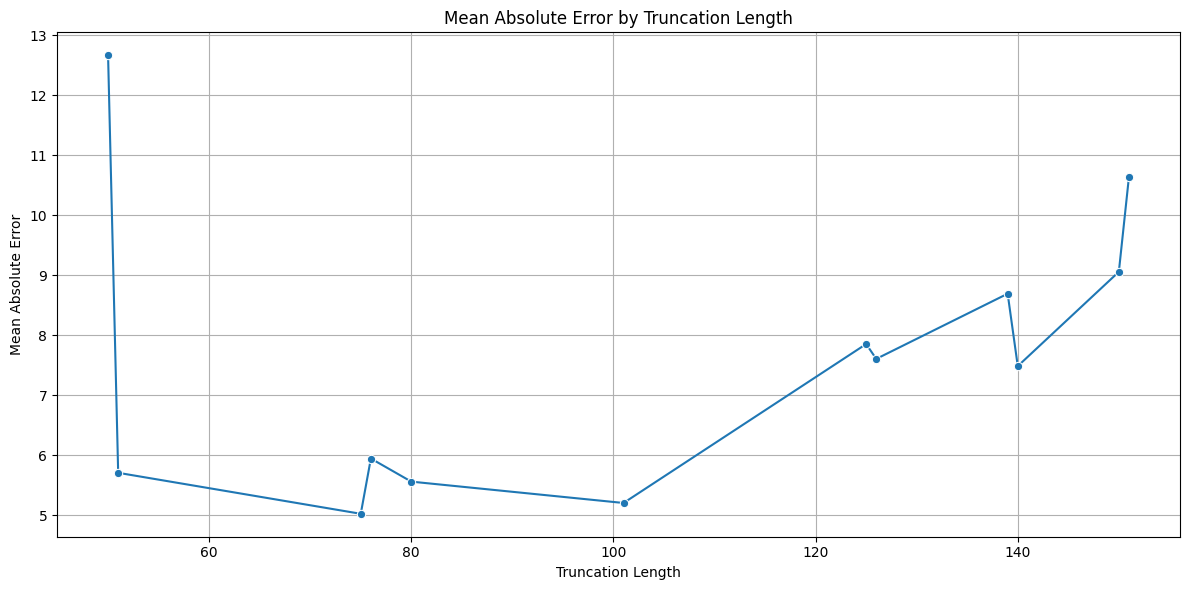

In [22]:
# Group by Ground Truth and calculate mean absolute error
error_by_length = df_results.groupby('Ground Truth')['Absolute Error'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x='Ground Truth', y='Absolute Error', data=error_by_length, marker='o')
plt.title('Mean Absolute Error by Truncation Length')
plt.xlabel('Truncation Length')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.tight_layout()
plt.show()

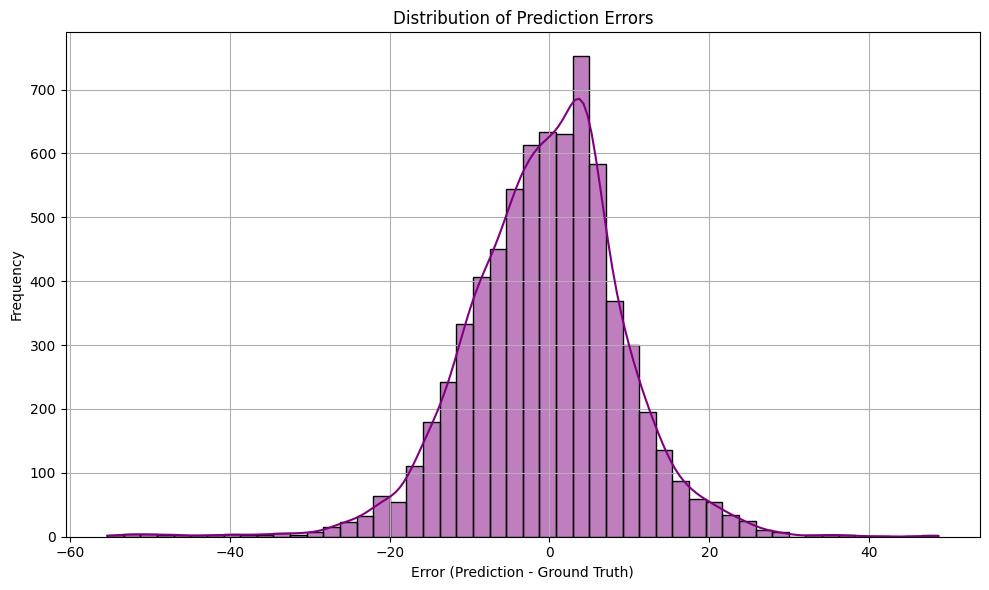

In [23]:
# Calculate errors
df_results['Error'] = df_results['Predictions'] - df_results['Ground Truth']

# Plot histogram of errors
plt.figure(figsize=(10,6))
sns.histplot(df_results['Error'], bins=50, kde=True, color='purple')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Prediction - Ground Truth)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Extract Top 50 Sequences with Closest Predictions
top_closest = df_results_sorted.head(50)
print("Top 50 Sequences with Closest Predictions to Ground Truth:")
print(top_closest[['Header', 'Ground Truth', 'Predictions', 'Absolute Error']])

# Extract Top 50 Sequences with Largest Errors
top_errors = df_results_sorted.tail(50)
print("Top 50 Sequences with Largest Errors:")
print(top_errors[['Header', 'Ground Truth', 'Predictions', 'Absolute Error']])


Top 50 Sequences with Closest Predictions to Ground Truth:
                                    Header  Ground Truth  Predictions  \
1286   SRR17272561_1_1:244706040-244707039         139.0   139.000824   
5860     SRR6663668_1_12:49763147-49764146          75.0    75.004845   
6705     SRR8083957_1_13:29513230-29514229         101.0   100.992661   
4107   SRR24508196_1_9:127691108-127692107         101.0   101.009666   
3922      SRR24508196_1_19:7470549-7471548         101.0   100.990105   
6521    SRR7075185_1_5:151267702-151268701          75.0    75.010963   
6337     SRR7075185_1_16:69696610-69697609          75.0    75.011147   
1650       SRR19520478_1_1:2589665-2590664         126.0   126.012848   
4016   SRR24508196_1_3:127690948-127691947         101.0   100.986900   
6086      SRR6663668_1_4:39778685-39779684          75.0    75.016716   
5963     SRR6663668_1_17:63589423-63590422          75.0    75.018333   
5330     SRR30598213_1_8:56962543-56963542         150.0   149.98

In [25]:
# Calculate the mean and standard deviation of Absolute Error for each segment (Header) across truncation lengths
segment_performance = df_results.groupby('Header').agg(
    mean_absolute_error=('Absolute Error', 'mean'),
    std_absolute_error=('Absolute Error', 'std'),
    count=('Absolute Error', 'count')  # Number of truncation lengths evaluated
).reset_index()

# Sort by mean absolute error to find best performing segments
segment_performance_sorted = segment_performance.sort_values('mean_absolute_error')

# Display the top 30 performing segments
print("Top 30 Segments with the Best Performance Across All Truncation Lengths:")
print(segment_performance_sorted.head(30))

# Extract bottom 30 performing segments
worst_segments = segment_performance_sorted.tail(30)

# Display the worst performing segments
print("\nWorst 30 Segments Across Truncation Lengths:")
print(worst_segments)

Top 30 Segments with the Best Performance Across All Truncation Lengths:
                                    Header  mean_absolute_error  \
1449   SRR17272561_1_1:244706040-244707039             0.000824   
5818     SRR6663668_1_12:49763147-49764146             0.004845   
6655     SRR8083957_1_13:29513230-29514229             0.007339   
4101   SRR24508196_1_9:127691108-127692107             0.009666   
3886      SRR24508196_1_19:7470549-7471548             0.009895   
6515    SRR7075185_1_5:151267702-151268701             0.010963   
6286     SRR7075185_1_16:69696610-69697609             0.011147   
1864       SRR19520478_1_1:2589665-2590664             0.012848   
4011   SRR24508196_1_3:127690948-127691947             0.013100   
6090      SRR6663668_1_4:39778685-39779684             0.016716   
5911     SRR6663668_1_17:63589423-63590422             0.018333   
5330     SRR30598213_1_8:56962543-56963542             0.019226   
1410    SRR17272561_1_19:45408425-45409424             0

In [26]:
from IPython.display import display, Javascript

# This command disconnects the current runtime
display(Javascript('google.colab.kernel.disconnect()'))


<IPython.core.display.Javascript object>